<a href="https://colab.research.google.com/github/jonkarrer/sales-forecasting-ml/blob/main/Sales_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Store Sales - Time Series Forcasting

In this competition, we will predict sales for the thousands of product families sold at Favorita stores located in Ecuador. The training data includes dates, store and product information, whether that item was being promoted, as well as the sales numbers. Additional files include supplementary information that may be useful in building your models.

In [1]:
from google.colab import userdata
from pathlib import Path
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

Install Kaggle

In [2]:
!pip install kaggle dtreeviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 2.2 MB/s eta 0:00:00


Sign into Kaggle using ENVs

In [3]:
kaggle_username = userdata.get('KAGGLE_USERNAME')
kaggle_key = userdata.get('KAGGLE_KEY')
creds=f'{{"username":"{kaggle_username}","key":"{kaggle_key}"}}'

os.environ['KAGGLE_USERNAME'] = kaggle_username
os.environ['KAGGLE_KEY'] = kaggle_key

COMPETITION_NAME = "store-sales-time-series-forecasting"

Grab the dataset from Kaggle

In [4]:
from kaggle import api

if not os.path.exists(COMPETITION_NAME):
    api.competition_download_cli(COMPETITION_NAME)

!kaggle competitions download -c store-sales-time-series-forecasting

# Unzip the dataset
import zipfile
import os

with zipfile.ZipFile(f"{COMPETITION_NAME}.zip", "r") as zip_ref:
    zip_ref.extractall(f"{COMPETITION_NAME}")

data_path = f"{COMPETITION_NAME}/train.csv"
df = pd.read_csv(data_path)
print(df.head())

100%|██████████| 21.4M/21.4M [00:00<00:00, 61.6MB/s]



store-sales-time-series-forecasting.zip: Skipping, found more recently modified local copy (use --force to force download)
   id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0


## Understanding the Data

In [48]:
tables_in_data = ["train.csv", "oil.csv", "stores.csv", "holidays_events.csv", "transactions.csv", "test.csv", "sample_submission.csv"]
for table in tables_in_data:
    print(table)
    df = pd.read_csv(f"{COMPETITION_NAME}/{table}", low_memory=False)
    print(df.head())

training_df = pd.read_csv(f"{COMPETITION_NAME}/train.csv", low_memory=False)
test_df = pd.read_csv(f"{COMPETITION_NAME}/test.csv", low_memory=False)
oil_df = pd.read_csv(f"{COMPETITION_NAME}/oil.csv", low_memory=False)
stores_df = pd.read_csv(f"{COMPETITION_NAME}/stores.csv", low_memory=False)
holiday_df = pd.read_csv(f"{COMPETITION_NAME}/holidays_events.csv", low_memory=False)
transactions_df = pd.read_csv(f"{COMPETITION_NAME}/transactions.csv", low_memory=False)

train.csv
   id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0
oil.csv
         date  dcoilwtico
0  2013-01-01         NaN
1  2013-01-02       93.14
2  2013-01-03       92.97
3  2013-01-04       93.12
4  2013-01-07       93.20
stores.csv
   store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4
holid

### Training Set

In [6]:
training_df.columns
training_df.tail()

,id,date,store_nbr,family,sales,onpromotion
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0


The training data, comprising time series of features id, date, store_nbr, family, and onpromotion as well as the target sales.

- store_nbr identifies the store at which the products are sold.
- family identifies the type of product sold.
- sales gives the total sales for a product family at a particular store at a - given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
- onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.
- date is when the sales occured
- id is the row identifier

In [7]:
training_df.nunique()

,0
id,3000888
date,1684
store_nbr,54
family,33
sales,379610
onpromotion,362


It seems that the family and store number are the most crucial aspects of this table.

In [8]:
print("** Store Number")
print(training_df["store_nbr"].unique())

print("** Family")
print(training_df["family"].unique())

** Store Number
[ 1 10 11 12 13 14 15 16 17 18 19  2 20 21 22 23 24 25 26 27 28 29  3 30
 31 32 33 34 35 36 37 38 39  4 40 41 42 43 44 45 46 47 48 49  5 50 51 52
 53 54  6  7  8  9]
** Family
['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD']


### Stores

- Store metadata, including city, state, type, and cluster.
- cluster is a grouping of similar stores.
- store_nbr should be what is in the uniques of the training set

In [9]:
stores_df.nunique()

,0
store_nbr,54
city,22
state,16
type,5
cluster,17


In [10]:
print("** Type")
print(stores_df["type"].unique())

print("** Cluster")
print(stores_df["cluster"].unique())

print("** City")
print(stores_df["city"].unique())

print("** State")
print(stores_df["state"].unique())

** Type
['D' 'B' 'C' 'E' 'A']
** Cluster
[13  8  9  4  6 15  7  3 12 16  1 10  2  5 11 14 17]
** City
['Quito' 'Santo Domingo' 'Cayambe' 'Latacunga' 'Riobamba' 'Ibarra'
 'Guaranda' 'Puyo' 'Ambato' 'Guayaquil' 'Salinas' 'Daule' 'Babahoyo'
 'Quevedo' 'Playas' 'Libertad' 'Cuenca' 'Loja' 'Machala' 'Esmeraldas'
 'Manta' 'El Carmen']
** State
['Pichincha' 'Santo Domingo de los Tsachilas' 'Cotopaxi' 'Chimborazo'
 'Imbabura' 'Bolivar' 'Pastaza' 'Tungurahua' 'Guayas' 'Santa Elena'
 'Los Rios' 'Azuay' 'Loja' 'El Oro' 'Esmeraldas' 'Manabi']


### Oil

Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

In [11]:
oil_df.nunique()

,0
date,1218
dcoilwtico,998


### Holiday Events

- Holidays and Events, with metadata
- NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
- Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

In [12]:
holiday_df.nunique()

,0
date,312
type,6
locale,3
locale_name,24
description,103
transferred,2


In [13]:
print("** Type")
print(holiday_df["type"].unique())

print("** Locale")
print(holiday_df["locale"].unique())

print("** Locale Name")
print(holiday_df["locale_name"].unique())

print("Transferred")
print(holiday_df["transferred"].unique())

** Type
['Holiday' 'Transfer' 'Additional' 'Bridge' 'Work Day' 'Event']
** Locale
['Local' 'Regional' 'National']
** Locale Name
['Manta' 'Cotopaxi' 'Cuenca' 'Libertad' 'Riobamba' 'Puyo' 'Guaranda'
 'Imbabura' 'Latacunga' 'Machala' 'Santo Domingo' 'El Carmen' 'Cayambe'
 'Esmeraldas' 'Ecuador' 'Ambato' 'Ibarra' 'Quevedo'
 'Santo Domingo de los Tsachilas' 'Santa Elena' 'Quito' 'Loja' 'Salinas'
 'Guayaquil']
Transferred
[False  True]


I would like to peak in and see how many holidays are type "transfer" or what is the count of "trasferred" is true

In [14]:
holiday_df["transferred"].value_counts()

,count
transferred,
False,338
True,12


Seeing that the transfer count is so low, I will remove them as an outlier most likely during data prep.

### Transactions

The date, store number, and how many transactions occured that day.

In [15]:
transactions_df.nunique()

,0
date,1682
store_nbr,54
transactions,4993


## Data Preperation

I think ultimatley we want a single table with as much enriched and useful data as possible on it. Our training dataset can enriched with data from our tables in theory.

### Dates

A common approach for dates is to expand them into day of the week or month and if it is a holiday.

In [16]:
# Remove the transferred holidays from the holiday_events.csv
if "transferred" in holiday_df.columns:
    holiday_df = holiday_df[holiday_df["transferred"] == False]
    holiday_df = holiday_df.drop(columns=["transferred", "description"])
    holiday_df = holiday_df[holiday_df["type"] != "Transfer"]

# Merge events from holiday events csv into train csv on date
merged_df = pd.merge(training_df, holiday_df[["date","type", "locale_name"]], on="date", how="left")
merged_df["type"] = merged_df["type"].fillna("Regular")
merged_df["locale_name"] = merged_df["locale_name"].fillna("Regular")
merged_df = merged_df.rename(columns={"type": "date_event", "locale_name": "date_event_locale"})

# Break dates into date parts
merged_df["date"] = pd.to_datetime(merged_df["date"])
merged_df["day_of_week"] = merged_df["date"].dt.dayofweek
merged_df["month"] = merged_df["date"].dt.month
merged_df["year"] = merged_df["date"].dt.year
merged_df["day_of_month"] = merged_df["date"].dt.day
merged_df["day_of_year"] = merged_df["date"].dt.dayofyear
merged_df["quarter_of_year"] = merged_df["date"].dt.quarter
merged_df["is_weekend"] = merged_df["day_of_week"].apply(lambda x: 1 if x in [5, 6] else 0)
merged_df.head()

,id,date,store_nbr,family,sales,onpromotion,date_event,date_event_locale,day_of_week,month,year,day_of_month,day_of_year,quarter_of_year,is_weekend
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Holiday,Ecuador,1,1,2013,1,1,1,0
1,1,2013-01-01,1,BABY CARE,0.0,0,Holiday,Ecuador,1,1,2013,1,1,1,0
2,2,2013-01-01,1,BEAUTY,0.0,0,Holiday,Ecuador,1,1,2013,1,1,1,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,Holiday,Ecuador,1,1,2013,1,1,1,0
4,4,2013-01-01,1,BOOKS,0.0,0,Holiday,Ecuador,1,1,2013,1,1,1,0


### Empty Data

Need to handle empty rows of data. Depending on the type of data, there are a few techniques.

In [17]:
# What is empty
merged_df.isna().sum()

,0
id,0
date,0
store_nbr,0
family,0
sales,0
onpromotion,0
date_event,0
date_event_locale,0
day_of_week,0
month,0


Turns out, there is nothing empty.

### Categorify

Next step is to turn catagories into numerical representations. They could be ordinal or not. In this case, the product family, date event and it's local are non ordinal categories.

In [18]:
merged_df["date_event"] = LabelEncoder().fit_transform(merged_df["date_event"])
merged_df["date_event_locale"] = LabelEncoder().fit_transform(merged_df["date_event_locale"])
merged_df["family"] = LabelEncoder().fit_transform(merged_df["family"])
merged_df.head()

,id,date,store_nbr,family,sales,onpromotion,date_event,date_event_locale,day_of_week,month,year,day_of_month,day_of_year,quarter_of_year,is_weekend
0,0,2013-01-01,1,0,0.0,0,3,4,1,1,2013,1,1,1,0
1,1,2013-01-01,1,1,0.0,0,3,4,1,1,2013,1,1,1,0
2,2,2013-01-01,1,2,0.0,0,3,4,1,1,2013,1,1,1,0
3,3,2013-01-01,1,3,0.0,0,3,4,1,1,2013,1,1,1,0
4,4,2013-01-01,1,4,0.0,0,3,4,1,1,2013,1,1,1,0


### Validation Set

Need to break off some of the training csv data into a validation csv. Since this is time series data, the validation set needs to be in the future.

In [19]:
# What are the date ranges
print(merged_df["date"].min())
print(merged_df["date"].max())

2013-01-01 00:00:00
2017-08-15 00:00:00


In [49]:
cutoff_date = pd.to_datetime("2017-01-01")
train_df = merged_df[merged_df["date"] < cutoff_date]
val_df = merged_df[merged_df["date"] >= cutoff_date]

train_df.shape, val_df.shape

((2640924, 15), (411642, 15))

## Modeling

Now that the data prep is done, we can get into deriving some insights on the data in terms of each features predictive power. The preffered first pass is a decision tree.

### Dependent and Independent Variables

This Kaggle competition tells us to use Root Mean Squared Log Error as our metric, and our goal is to predict the sales column. So we should go ahead and make the sales column the log of the sales, but we need to handle zero sales. To do this we use the log1p method from numpy.

In [21]:
dep_var = "sales"
val_df[dep_var] = np.log1p(val_df[dep_var])
train_df[dep_var] = np.log1p(train_df[dep_var])

y_train = train_df[dep_var]
x_train = train_df.drop(columns=[dep_var, "id", "date"])
indep_vars = x_train.columns.tolist()
print(indep_vars)

y_val = val_df[dep_var]
x_val = val_df.drop(columns=[dep_var, "id", "date"])

<ipython-input-21-1cfb32b13a1d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df[dep_var] = np.log1p(val_df[dep_var])
<ipython-input-21-1cfb32b13a1d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[dep_var] = np.log1p(train_df[dep_var])


['store_nbr', 'family', 'onpromotion', 'date_event', 'date_event_locale', 'day_of_week', 'month', 'year', 'day_of_month', 'day_of_year', 'quarter_of_year', 'is_weekend']


### Decision Tree Training

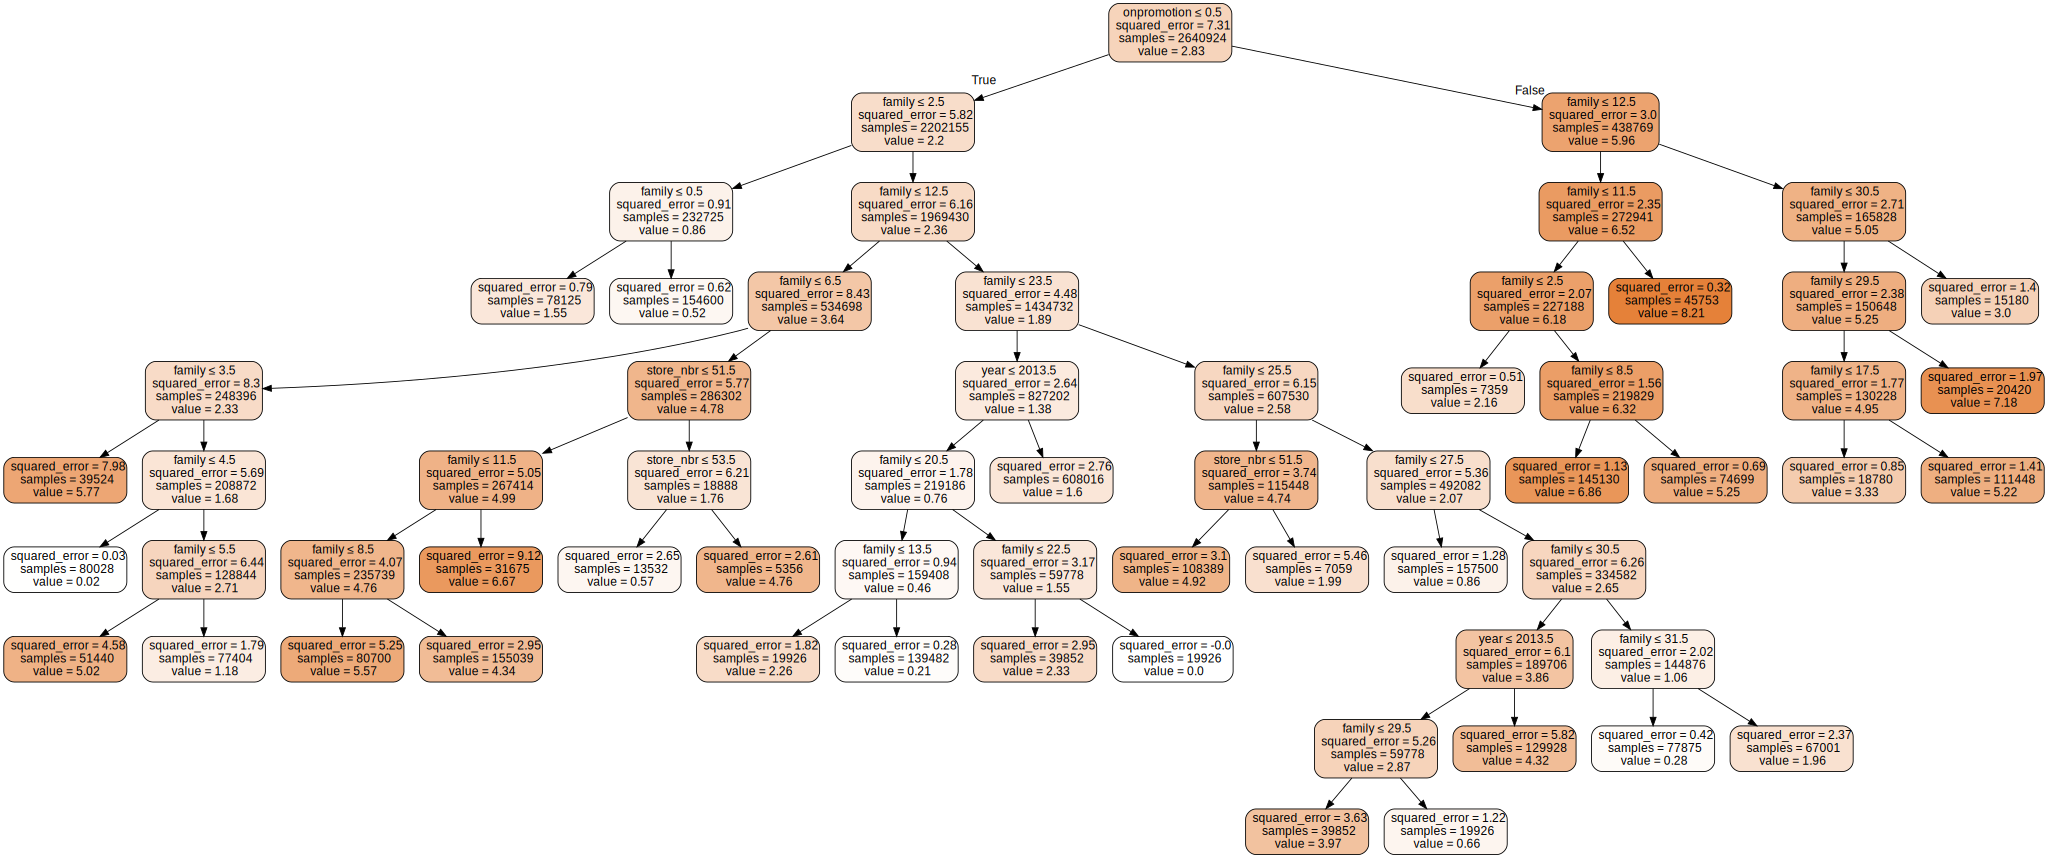

In [22]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import graphviz
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

model = DecisionTreeRegressor(max_leaf_nodes=32)
model.fit(x_train, y_train)

# Plot the decision tree
# plt.figure(figsize=(40,10))
# plot_tree(model, filled=True, feature_names=indep_vars)
# plt.show()

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, impurity=True, **kwargs)
    return graphviz.Source(s)

draw_tree(model, x_train, size=20)

### Decision Tree Validation

In [23]:
from logging import root
from sklearn.metrics import root_mean_squared_log_error

y_pred = model.predict(x_val)
rmsle = root_mean_squared_log_error(y_val, y_pred)
print(f"RMSLE: {rmsle}")

RMSLE: 0.39841535421097896


### Decision Tree Test

In [24]:
test_df = pd.read_csv(f"{COMPETITION_NAME}/test.csv", low_memory=False)

# Add event data
prepped_test_df = pd.merge(test_df, holiday_df[["date","type", "locale_name"]], on="date", how="left")
prepped_test_df["type"] = prepped_test_df["type"].fillna("Regular")
prepped_test_df["locale_name"] = prepped_test_df["locale_name"].fillna("Regular")
prepped_test_df = prepped_test_df.rename(columns={"type": "date_event", "locale_name": "date_event_locale"})

# Datepart dates
prepped_test_df["date"] = pd.to_datetime(prepped_test_df["date"])
prepped_test_df["day_of_week"] = prepped_test_df["date"].dt.dayofweek
prepped_test_df["month"] = prepped_test_df["date"].dt.month
prepped_test_df["year"] = prepped_test_df["date"].dt.year
prepped_test_df["day_of_month"] = prepped_test_df["date"].dt.day
prepped_test_df["day_of_year"] = prepped_test_df["date"].dt.dayofyear
prepped_test_df["quarter_of_year"] = prepped_test_df["date"].dt.quarter
prepped_test_df["is_weekend"] = prepped_test_df["day_of_week"].apply(lambda x: 1 if x in [5, 6] else 0)

# Encode categories
prepped_test_df["date_event"] = LabelEncoder().fit_transform(prepped_test_df["date_event"])
prepped_test_df["date_event_locale"] = LabelEncoder().fit_transform(prepped_test_df["date_event_locale"])
prepped_test_df["family"] = LabelEncoder().fit_transform(prepped_test_df["family"])

x_test = prepped_test_df.drop(columns=["id", "date"])

y_pred = model.predict(x_test)

test_df["sales"] = np.expm1(y_pred)
sub_df = test_df[["id","sales"]]
sub_df.to_csv(f'sub-sales-forcasting.csv', index=False)

A single decision tree is not all that powerful of course, but serves as a good data analysis tool. Though our loss metric was 0.05, the Kaggle score thus far is 4.20226. Rather pathetic, but hey the mvp was submitted. Time to gain some insights and see what can be done to improve on the single decision tree.

## Experimenting

### Hypothesis: Product Family is noise

The decision tree decided to split on family after onpromotion. I suspect this is not the next best split.

<ipython-input-25-a6b8f2a523de>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df[dep_var] = np.log1p(val_df[dep_var])
<ipython-input-25-a6b8f2a523de>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[dep_var] = np.log1p(train_df[dep_var])


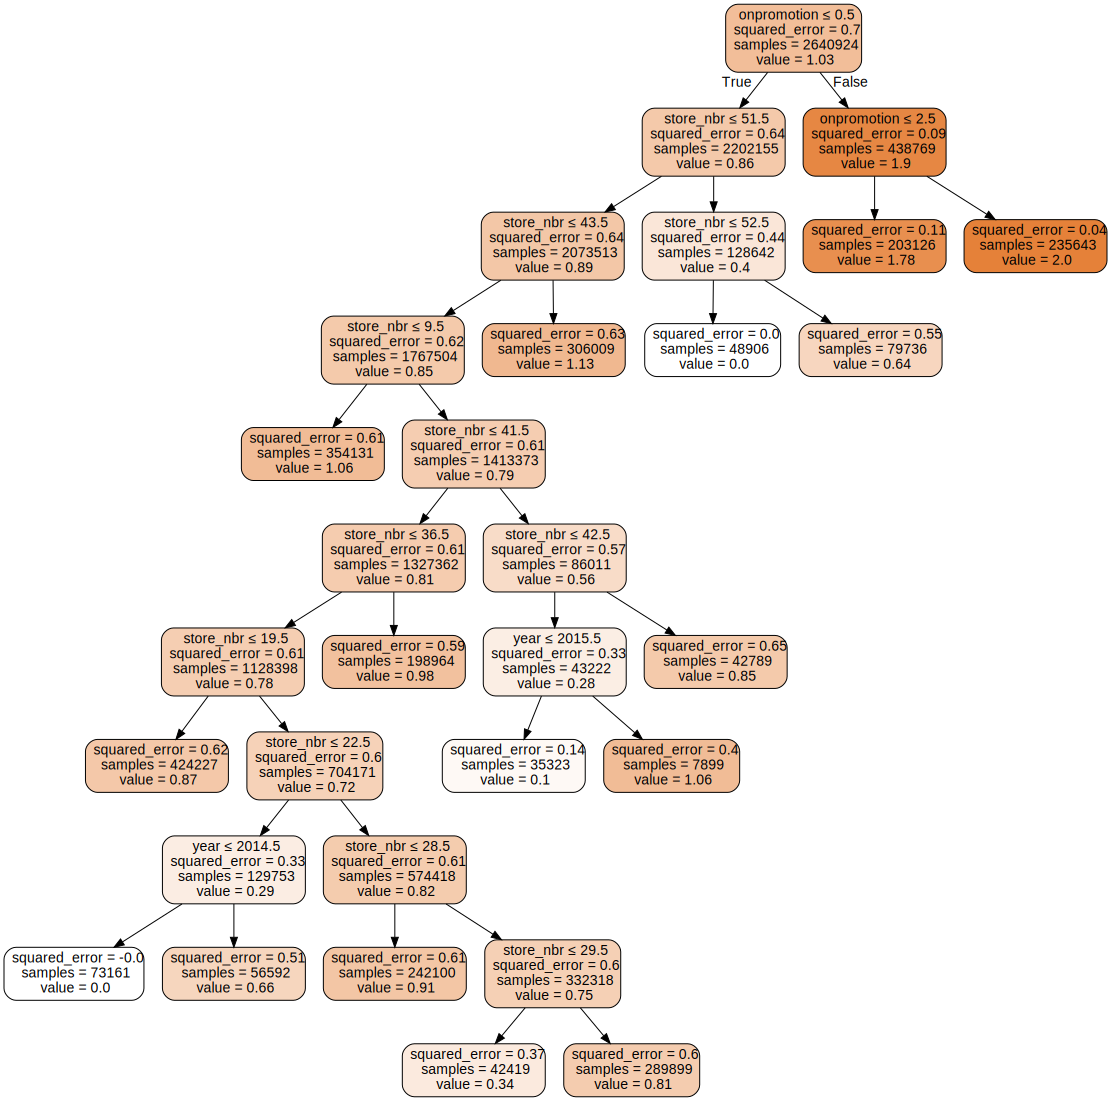

In [25]:
dep_var = "sales"
val_df[dep_var] = np.log1p(val_df[dep_var])
train_df[dep_var] = np.log1p(train_df[dep_var])

y_train = train_df[dep_var]
x_train = train_df.drop(columns=[dep_var, "id", "date", "family"])
indep_vars = x_train.columns.tolist()

y_val = val_df[dep_var]
x_val = val_df.drop(columns=[dep_var, "id", "date", "family"])

model = DecisionTreeRegressor(max_leaf_nodes=16)
model.fit(x_train, y_train)

draw_tree(model, x_train, size=20)

In [26]:
y_pred = model.predict(x_val)
rmsle = root_mean_squared_log_error(y_val, y_pred)
print(f"RMSLE: {rmsle}")

RMSLE: 0.2975966424902258


This does reduce our rmsle.

### Hypothesis: Year is noise

Year does not seem to matter much for sales prediction.

<ipython-input-27-22dd024f279f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df[dep_var] = np.log1p(val_df[dep_var])
<ipython-input-27-22dd024f279f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[dep_var] = np.log1p(train_df[dep_var])


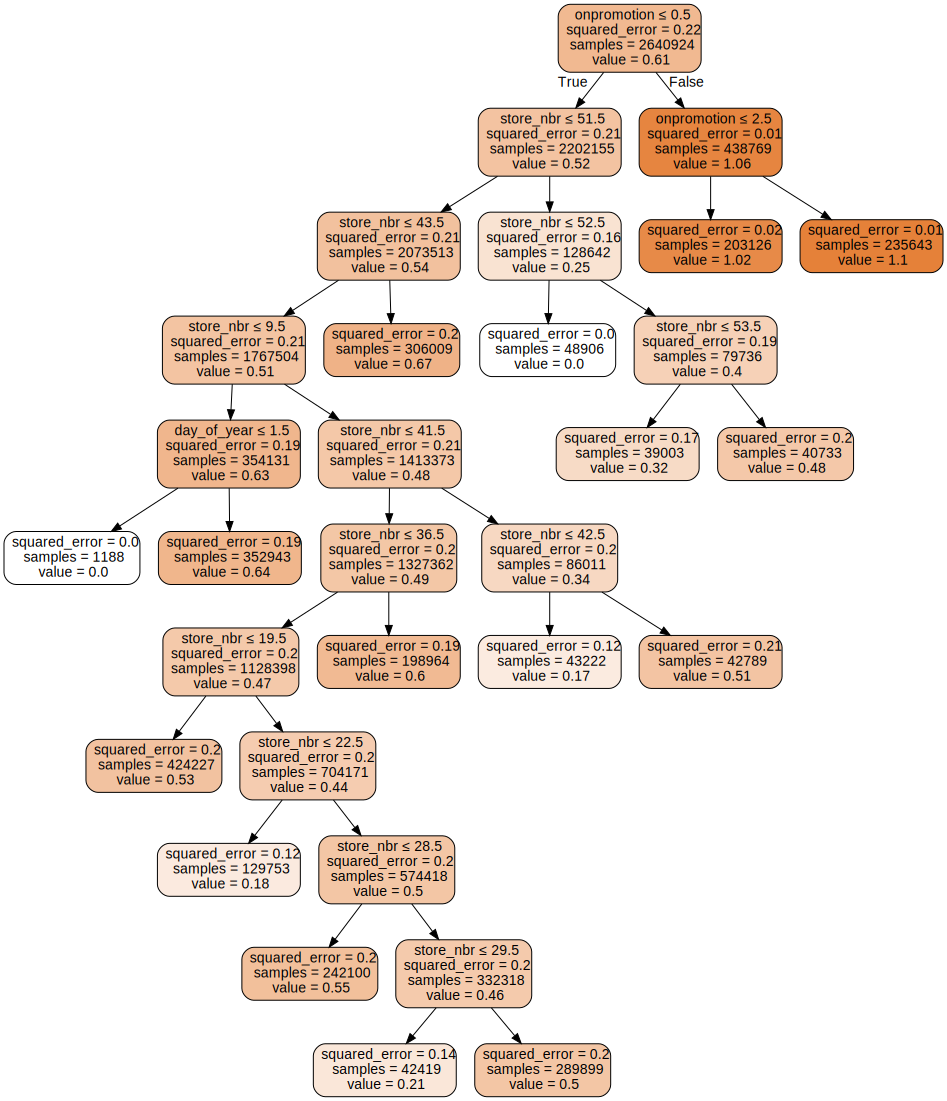

In [27]:
dep_var = "sales"
val_df[dep_var] = np.log1p(val_df[dep_var])
train_df[dep_var] = np.log1p(train_df[dep_var])

y_train = train_df[dep_var]
x_train = train_df.drop(columns=[dep_var, "id", "date", "family", "year"])
indep_vars = x_train.columns.tolist()

y_val = val_df[dep_var]
x_val = val_df.drop(columns=[dep_var, "id", "date", "family", "year"])

model = DecisionTreeRegressor(max_leaf_nodes=16)
model.fit(x_train, y_train)

draw_tree(model, x_train, size=20)

In [28]:
y_pred = model.predict(x_val)
rmsle = root_mean_squared_log_error(y_val, y_pred)
print(f"RMSLE: {rmsle}")

RMSLE: 0.2097042766921296


Conclusion: removing the year does improve the RMSLE

### Hypothesis: Need to run some coefficent calcs and imortance calcs.

In [29]:
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': x_train.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

             Feature  Importance
1        onpromotion    0.672278
0          store_nbr    0.324727
7        day_of_year    0.002995
2         date_event    0.000000
3  date_event_locale    0.000000
4        day_of_week    0.000000
5              month    0.000000
6       day_of_month    0.000000
8    quarter_of_year    0.000000
9         is_weekend    0.000000


Given these importance readings, we could grow the tree for more insights. A pearson correlation could work too.

In [30]:
x_train = train_df.drop(columns=["id", "date", "year"])

correlations = x_train.corr()['sales']
print(correlations)

store_nbr           -0.035124
family              -0.035717
sales                1.000000
onpromotion          0.195420
date_event          -0.030947
date_event_locale   -0.016235
day_of_week          0.014141
month                0.075663
day_of_month         0.003067
day_of_year          0.076155
quarter_of_year      0.073056
is_weekend           0.020491
Name: sales, dtype: float64


Seems store_nbr, family, date_event, date_event_locale, day_of_week, and is_weekend can be dropped with little issue.

<ipython-input-31-76f38907dceb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df[dep_var] = np.log1p(val_df[dep_var])
<ipython-input-31-76f38907dceb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[dep_var] = np.log1p(train_df[dep_var])


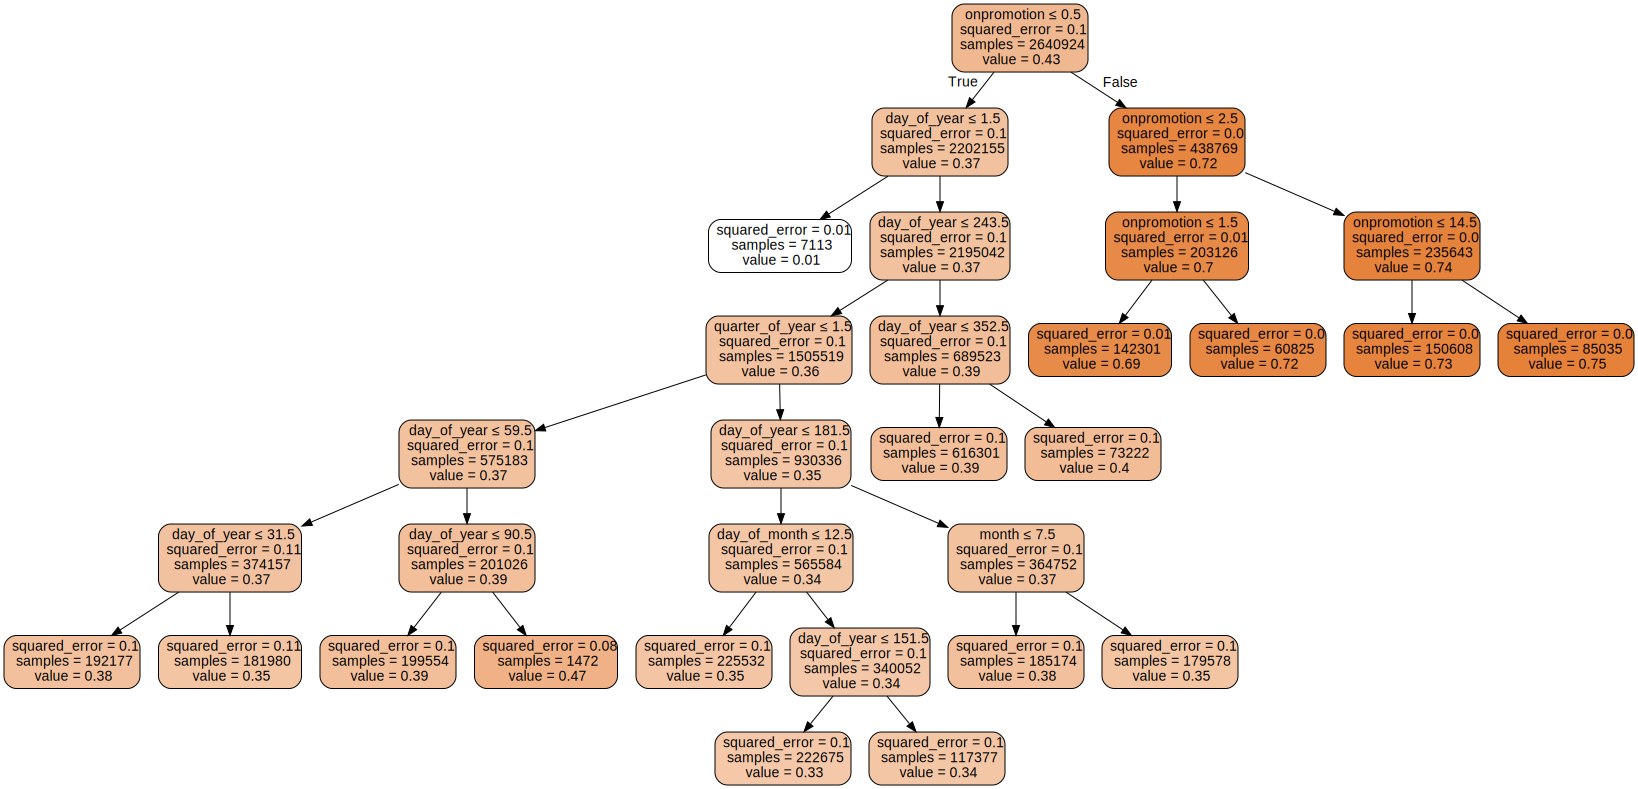

In [31]:
dep_var = "sales"
val_df[dep_var] = np.log1p(val_df[dep_var])
train_df[dep_var] = np.log1p(train_df[dep_var])

y_train = train_df[dep_var]
x_train = train_df.drop(columns=[dep_var, "id", "date", "family", "year", "store_nbr", "date_event", "date_event_locale", "day_of_week", "is_weekend"])
indep_vars = x_train.columns.tolist()

y_val = val_df[dep_var]
x_val = val_df.drop(columns=[dep_var, "id", "date", "family", "year", "store_nbr", "date_event", "date_event_locale", "day_of_week", "is_weekend"])

model = DecisionTreeRegressor(max_leaf_nodes=16)
model.fit(x_train, y_train)

draw_tree(model, x_train, size=20)

In [32]:
y_pred = model.predict(x_val)
rmsle = root_mean_squared_log_error(y_val, y_pred)
print(f"RMSLE: {rmsle}")

RMSLE: 0.15705576256151574


RMSLE: 0.157 is the lowest score yet.

In [35]:
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': x_train.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

           Feature  Importance
0      onpromotion    0.959233
3      day_of_year    0.035050
4  quarter_of_year    0.003690
1            month    0.001527
2     day_of_month    0.000501


In [36]:
model.get_n_leaves(), len(x_train)

(16, 2640924)

### Hypothesis: Need to find the optimal size

16 nodes got us to RMSLE: 0.15, so how about 32.

In [37]:
dep_var = "sales"
val_df[dep_var] = np.log1p(val_df[dep_var])
train_df[dep_var] = np.log1p(train_df[dep_var])

y_train = train_df[dep_var]
x_train = train_df.drop(columns=[dep_var, "id", "date", "family", "year", "store_nbr", "date_event", "date_event_locale", "day_of_week", "is_weekend"])
indep_vars = x_train.columns.tolist()

y_val = val_df[dep_var]
x_val = val_df.drop(columns=[dep_var, "id", "date", "family", "year", "store_nbr", "date_event", "date_event_locale", "day_of_week", "is_weekend"])

model = DecisionTreeRegressor(max_leaf_nodes=32)
model.fit(x_train, y_train)

y_pred = model.predict(x_val)
rmsle = root_mean_squared_log_error(y_val, y_pred)
print(f"RMSLE: {rmsle}")


<ipython-input-37-a2f699c2e332>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df[dep_var] = np.log1p(val_df[dep_var])
<ipython-input-37-a2f699c2e332>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[dep_var] = np.log1p(train_df[dep_var])


RMSLE: 0.12796273193840704


32 nodes gets us RMSLE 0.12. How about 64.

In [39]:
dep_var = "sales"
val_df[dep_var] = np.log1p(val_df[dep_var])
train_df[dep_var] = np.log1p(train_df[dep_var])

y_train = train_df[dep_var]
x_train = train_df.drop(columns=[dep_var, "id", "date", "family", "year", "store_nbr", "date_event", "date_event_locale", "day_of_week", "is_weekend"])
indep_vars = x_train.columns.tolist()

y_val = val_df[dep_var]
x_val = val_df.drop(columns=[dep_var, "id", "date", "family", "year", "store_nbr", "date_event", "date_event_locale", "day_of_week", "is_weekend"])

model = DecisionTreeRegressor(max_leaf_nodes=64)
model.fit(x_train, y_train)

y_pred = model.predict(x_val)
rmsle = root_mean_squared_log_error(y_val, y_pred)
print(f"RMSLE: {rmsle}")

<ipython-input-39-23710f9b1273>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df[dep_var] = np.log1p(val_df[dep_var])
<ipython-input-39-23710f9b1273>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[dep_var] = np.log1p(train_df[dep_var])


RMSLE: 0.09376717695546662


64 nodes gets us RMSLE 0.093. How about 128

In [40]:
dep_var = "sales"
val_df[dep_var] = np.log1p(val_df[dep_var])
train_df[dep_var] = np.log1p(train_df[dep_var])

y_train = train_df[dep_var]
x_train = train_df.drop(columns=[dep_var, "id", "date", "family", "year", "store_nbr", "date_event", "date_event_locale", "day_of_week", "is_weekend"])
indep_vars = x_train.columns.tolist()

y_val = val_df[dep_var]
x_val = val_df.drop(columns=[dep_var, "id", "date", "family", "year", "store_nbr", "date_event", "date_event_locale", "day_of_week", "is_weekend"])

model = DecisionTreeRegressor(max_leaf_nodes=128)
model.fit(x_train, y_train)

y_pred = model.predict(x_val)
rmsle = root_mean_squared_log_error(y_val, y_pred)
print(f"RMSLE: {rmsle}")

<ipython-input-40-7deb5f9cb915>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df[dep_var] = np.log1p(val_df[dep_var])
<ipython-input-40-7deb5f9cb915>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[dep_var] = np.log1p(train_df[dep_var])


RMSLE: 0.08303374256575342


128 nodes gets RMSLE: 0.083. Going to stop here because of the fear of overfitting. Submitting to kaggle moves our score from a 4.22 to a 4.16. Mehhh

In [41]:
test_df = pd.read_csv(f"{COMPETITION_NAME}/test.csv", low_memory=False)

# Add event data
prepped_test_df = pd.merge(test_df, holiday_df[["date","type", "locale_name"]], on="date", how="left")
prepped_test_df["type"] = prepped_test_df["type"].fillna("Regular")
prepped_test_df["locale_name"] = prepped_test_df["locale_name"].fillna("Regular")
prepped_test_df = prepped_test_df.rename(columns={"type": "date_event", "locale_name": "date_event_locale"})

# Datepart dates
prepped_test_df["date"] = pd.to_datetime(prepped_test_df["date"])
prepped_test_df["day_of_week"] = prepped_test_df["date"].dt.dayofweek
prepped_test_df["month"] = prepped_test_df["date"].dt.month
prepped_test_df["year"] = prepped_test_df["date"].dt.year
prepped_test_df["day_of_month"] = prepped_test_df["date"].dt.day
prepped_test_df["day_of_year"] = prepped_test_df["date"].dt.dayofyear
prepped_test_df["quarter_of_year"] = prepped_test_df["date"].dt.quarter
prepped_test_df["is_weekend"] = prepped_test_df["day_of_week"].apply(lambda x: 1 if x in [5, 6] else 0)

# Encode categories
prepped_test_df["date_event"] = LabelEncoder().fit_transform(prepped_test_df["date_event"])
prepped_test_df["date_event_locale"] = LabelEncoder().fit_transform(prepped_test_df["date_event_locale"])
prepped_test_df["family"] = LabelEncoder().fit_transform(prepped_test_df["family"])

x_test = prepped_test_df.drop(columns=["id", "date", "family", "year", "store_nbr", "date_event", "date_event_locale", "day_of_week", "is_weekend"])

y_pred = model.predict(x_test)

test_df["sales"] = np.expm1(y_pred)
sub_df = test_df[["id","sales"]]
sub_df.to_csv(f'sub-sales-forcasting.csv', index=False)

## Random Forest

In [42]:
from sklearn.ensemble import RandomForestRegressor

dep_var = "sales"
# val_df[dep_var] = np.log1p(val_df[dep_var])
# train_df[dep_var] = np.log1p(train_df[dep_var])

y_train = train_df[dep_var]
x_train = train_df.drop(columns=[dep_var, "id", "date", "family", "year", "store_nbr", "date_event", "date_event_locale", "day_of_week", "is_weekend"])
indep_vars = x_train.columns.tolist()

y_val = val_df[dep_var]
x_val = val_df.drop(columns=[dep_var, "id", "date", "family", "year", "store_nbr", "date_event", "date_event_locale", "day_of_week", "is_weekend"])

model = RandomForestRegressor(n_estimators=100, max_leaf_nodes=128)
model.fit(x_train, y_train)

y_pred = model.predict(x_val)
rmsle = root_mean_squared_log_error(y_val, y_pred)
print(f"RMSLE: {rmsle}")

<ipython-input-42-c250553b241b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df[dep_var] = np.log1p(val_df[dep_var])
<ipython-input-42-c250553b241b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[dep_var] = np.log1p(train_df[dep_var])


RMSLE: 0.07426137513546269


That config dropped our RMSLE from 0.08 to 0.074, not bad nor great. Going to ramp it up in the name of science.

In [51]:
from sklearn.ensemble import RandomForestRegressor

dep_var = "sales"
val_df[dep_var] = np.log1p(val_df[dep_var])
train_df[dep_var] = np.log1p(train_df[dep_var])

y_train = train_df[dep_var]
x_train = train_df.drop(columns=[dep_var, "id", "date", "family", "year", "store_nbr", "date_event", "date_event_locale", "day_of_week", "is_weekend"])
indep_vars = x_train.columns.tolist()

y_val = val_df[dep_var]
x_val = val_df.drop(columns=[dep_var, "id", "date", "family", "year", "store_nbr", "date_event", "date_event_locale", "day_of_week", "is_weekend"])

model = RandomForestRegressor(
    n_estimators=200,          # Increased number of trees
    max_depth=20,              # Increased maximum depth
    min_samples_split=5,       # Minimum number of samples required to split an internal node
    min_samples_leaf=2,        # Minimum number of samples required to be at a leaf node
    max_features='sqrt',       # Number of features to consider when looking for the best split
    bootstrap=True,            # Whether bootstrap samples are used when building trees
    max_leaf_nodes=256         # Increased maximum number of leaf nodes
)
model.fit(x_train, y_train)

y_pred = model.predict(x_val)
rmsle = root_mean_squared_log_error(y_val, y_pred)
print(f"RMSLE: {rmsle}")

<ipython-input-51-568991b39d95>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df[dep_var] = np.log1p(val_df[dep_var])
<ipython-input-51-568991b39d95>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[dep_var] = np.log1p(train_df[dep_var])


RMSLE: 0.5635257383998276


In [52]:
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': x_train.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

           Feature  Importance
0      onpromotion    0.970248
3      day_of_year    0.016776
1            month    0.006252
2     day_of_month    0.003502
4  quarter_of_year    0.003223


Not a huge leap, 0.074 to 0.0672. Let's submit to Kaggle

In [47]:
test_df = pd.read_csv(f"{COMPETITION_NAME}/test.csv", low_memory=False)

# Add event data
prepped_test_df = pd.merge(test_df, holiday_df[["date","type", "locale_name"]], on="date", how="left")
prepped_test_df["type"] = prepped_test_df["type"].fillna("Regular")
prepped_test_df["locale_name"] = prepped_test_df["locale_name"].fillna("Regular")
prepped_test_df = prepped_test_df.rename(columns={"type": "date_event", "locale_name": "date_event_locale"})

# Datepart dates
prepped_test_df["date"] = pd.to_datetime(prepped_test_df["date"])
prepped_test_df["day_of_week"] = prepped_test_df["date"].dt.dayofweek
prepped_test_df["month"] = prepped_test_df["date"].dt.month
prepped_test_df["year"] = prepped_test_df["date"].dt.year
prepped_test_df["day_of_month"] = prepped_test_df["date"].dt.day
prepped_test_df["day_of_year"] = prepped_test_df["date"].dt.dayofyear
prepped_test_df["quarter_of_year"] = prepped_test_df["date"].dt.quarter
prepped_test_df["is_weekend"] = prepped_test_df["day_of_week"].apply(lambda x: 1 if x in [5, 6] else 0)

# Encode categories
prepped_test_df["date_event"] = LabelEncoder().fit_transform(prepped_test_df["date_event"])
prepped_test_df["date_event_locale"] = LabelEncoder().fit_transform(prepped_test_df["date_event_locale"])
prepped_test_df["family"] = LabelEncoder().fit_transform(prepped_test_df["family"])

x_test = prepped_test_df.drop(columns=["id", "date", "family", "year", "store_nbr", "date_event", "date_event_locale", "day_of_week", "is_weekend"])

y_pred = model.predict(x_test)

test_df["sales"] = y_pred
sub_df = test_df[["id","sales"]]
sub_df.to_csv(f'sub-sales-forcasting-rf.csv', index=False)

Not great. Another 4.2 score. So it seems there needs to be more work in prepping the data.